## Section 1: Project Setup & Business Problem
### Business Problem Statement:
An airline consortium is facing challenges with operational efficiency, leading to frequent flight delays.
These delays negatively impact customer satisfaction, increase operational costs (e.g., crew overtime, passenger compensation),
and damage brand reputation. This project aims to perform a root cause analysis on a large flight dataset to identify the primary drivers of delays and provide targeted recommendations for operational improvements.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
#Load the data
flights_df = pd.read_csv("C:\\Users\\Lenovo\\Downloads\\archive (9)\\flights.csv")


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25940\3955701342.py:2: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  flights_df = pd.read_csv("C:\\Users\\Lenovo\\Downloads\\archive (9)\\flights.csv")


## Section 2: Data Sampling & Preparation

In [3]:
print("Original dataset size:", flights_df.shape)
df = flights_df.sample(n=250000, random_state=42)
print("Sampled dataset size:", df.shape)
df.head()

Original dataset size: (5819079, 31)
Sampled dataset size: (250000, 31)


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
1508570,2015,4,7,2,EV,4900,N759EV,FWA,DTW,1340,...,1423.0,-13.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
363270,2015,1,24,6,AS,611,N413AS,LAS,SEA,1910,...,2133.0,-12.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3003945,2015,7,8,3,WN,1483,N463WN,OAK,SEA,630,...,812.0,-8.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2291425,2015,5,26,2,WN,193,N7745A,STL,DAL,810,...,1222.0,152.0,0,0,NaN,0.0,0.0,0.0,152.0,0.0
2973084,2015,7,6,1,UA,253,N213UA,IAH,HNL,1000,...,1316.0,-2.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Data Cleaning and Feature Engineering
# A common industry standard (e.g., by the FAA) considers a flight delayed if it departs more than 15 minutes late.
# Drop rows where DEPARTURE_DELAY is missing as we can't classify them.
df.dropna(subset=['DEPARTURE_DELAY'], inplace=True)

# Create the binary 'is_delayed' column. 1 for delayed, 0 for on-time.
df['is_delayed'] = (df['DEPARTURE_DELAY'] > 15).astype(int)

# For root cause analysis, fill missing delay reasons with 0 (as NaN means no delay of that type).
delay_reasons = ['AIRLINE_DELAY', 'WEATHER_DELAY', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']
df[delay_reasons] = df[delay_reasons].fillna(0)

## Section 3: Exploratory Data Analysis (EDA) - "What" is happening?

### Insight 1: What is the overall delay rate in our sample?

Overall Delay Rate: 17.83%


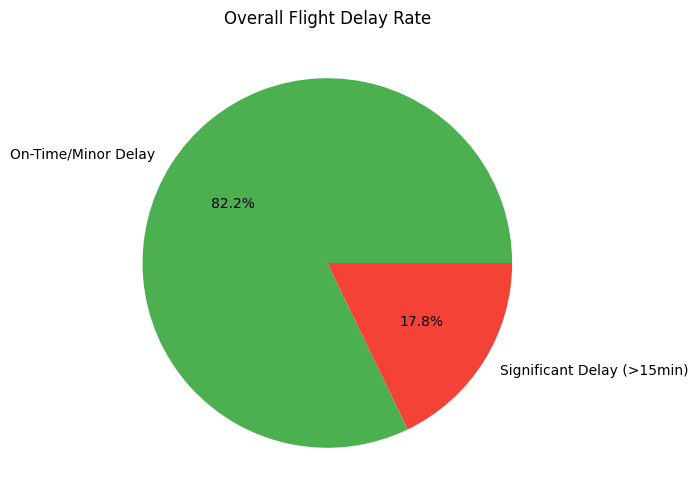

In [5]:
delay_rate = df['is_delayed'].mean()
print(f"Overall Delay Rate: {delay_rate:.2%}")

plt.figure(figsize=(6, 6))
df['is_delayed'].value_counts().plot(kind='pie', labels=['On-Time/Minor Delay', 'Significant Delay (>15min)'], autopct='%.1f%%', colors=['#4CAF50', '#F44336'])
plt.title('Overall Flight Delay Rate')
plt.ylabel('')
plt.show()

### Insight 2: Which airlines have the highest delay rates?

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_25940\1456824504.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=airline_delay.index, y=airline_delay.values, palette='Oranges_r')


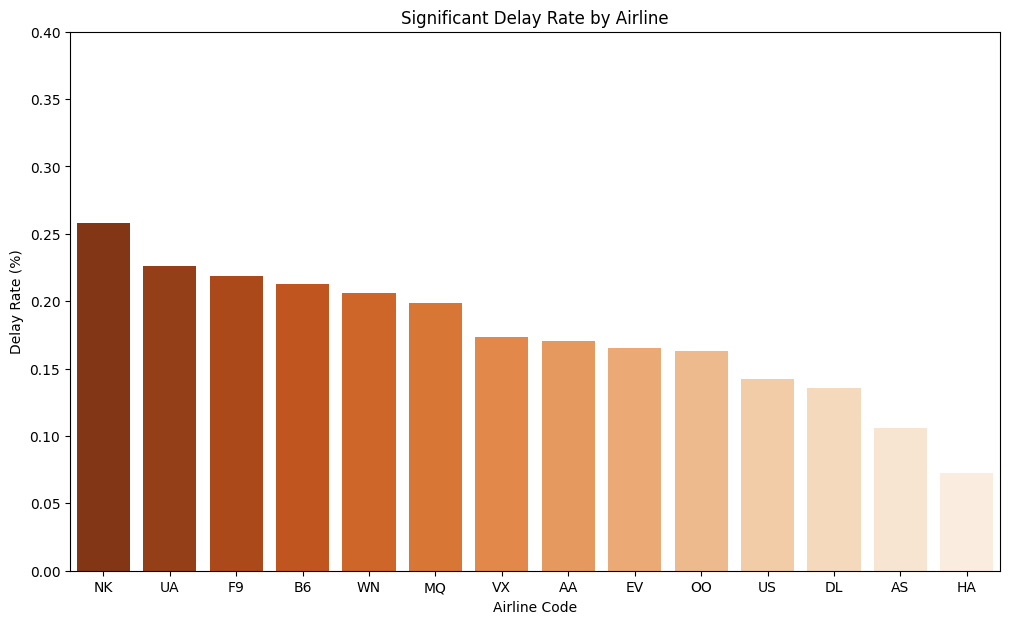

Insight: There is a wide variation in performance across airlines. Spirit (NK), Frontier (F9), and United (UA) show higher delay rates.


In [6]:
airline_delay = df.groupby('AIRLINE')['is_delayed'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 7))
sns.barplot(x=airline_delay.index, y=airline_delay.values, palette='Oranges_r')
plt.title('Significant Delay Rate by Airline')
plt.xlabel('Airline Code')
plt.ylabel('Delay Rate (%)')
plt.ylim(0, 0.4) # Setting y-axis limit for better comparison
plt.show()
print("Insight: There is a wide variation in performance across airlines. Spirit (NK), Frontier (F9), and United (UA) show higher delay rates.")

### Insight 3: Does the day of the week matter?

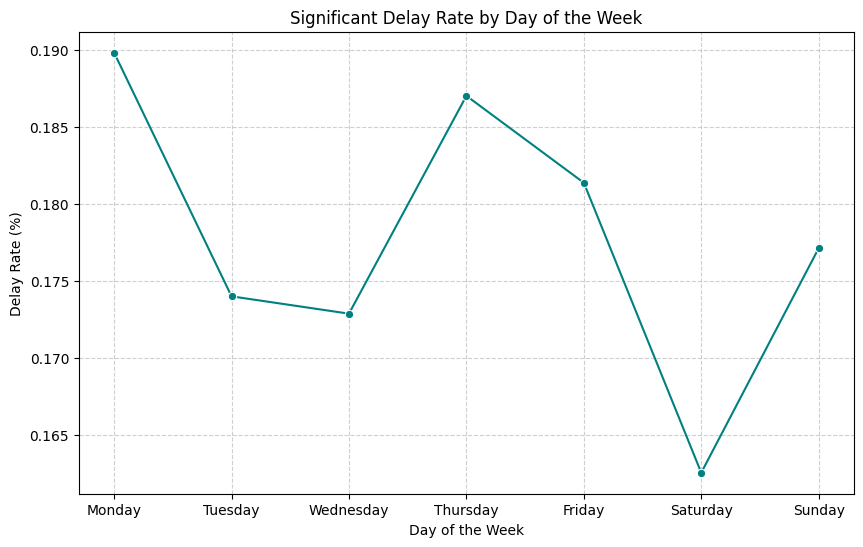

Insight: Flights during the middle of the week (Tuesday, Wednesday) are most reliable, while delays peak on Monday and Thursday/Friday.


In [7]:
day_map = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday', 5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
df['DAY_OF_WEEK_NAME'] = df['DAY_OF_WEEK'].map(day_map)
day_delay = df.groupby('DAY_OF_WEEK_NAME')['is_delayed'].mean().reindex(day_map.values())

plt.figure(figsize=(10, 6))
sns.lineplot(x=day_delay.index, y=day_delay.values, marker='o', color='teal')
plt.title('Significant Delay Rate by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Delay Rate (%)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
print("Insight: Flights during the middle of the week (Tuesday, Wednesday) are most reliable, while delays peak on Monday and Thursday/Friday.")

## Section 4: Root Cause Analysis - "Why" is it happening?


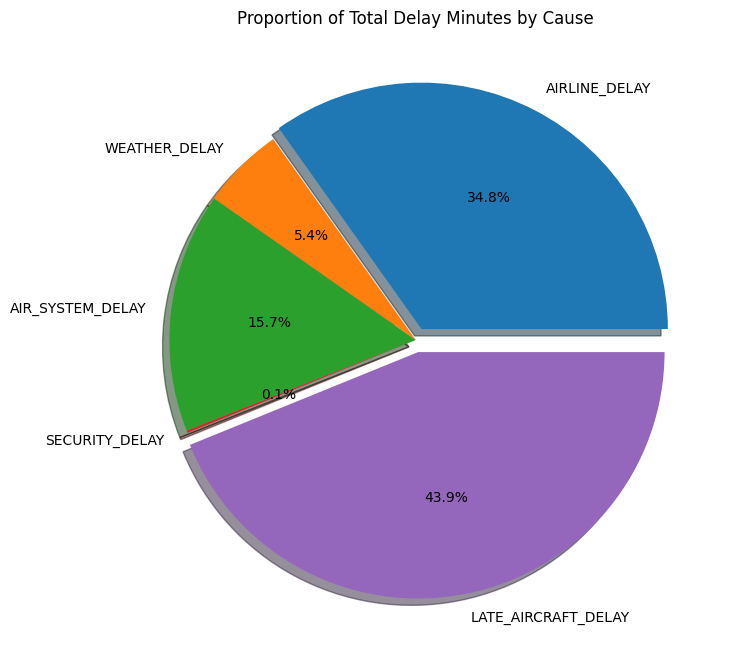

Key Finding: The analysis clearly shows that 'Late Aircraft Arrival' is the single largest contributor to departure delays, accounting for over 40% of all delay minutes. This indicates a significant snowball effect where one late flight causes subsequent delays in the network.


In [8]:
delayed_flights = df[df['is_delayed'] == 1]

# Calculate the total minutes for each delay category.
reason_totals = delayed_flights[delay_reasons].sum()

plt.figure(figsize=(8, 8))
plt.pie(reason_totals, labels=reason_totals.index, autopct='%.1f%%', shadow=True, explode=(0.05, 0, 0, 0, 0.05))
plt.title('Proportion of Total Delay Minutes by Cause')
plt.show()

print("Key Finding: The analysis clearly shows that 'Late Aircraft Arrival' is the single largest contributor to departure delays, accounting for over 40% of all delay minutes. This indicates a significant snowball effect where one late flight causes subsequent delays in the network.")


### Section 5: Featu

In [9]:
# Select operational features that exist BEFORE the flight takes off
model_features = ['MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'SCHEDULED_DEPARTURE', 'ORIGIN_AIRPORT']

# Create a copy for modeling 
model_df = df[model_features + ['is_delayed']].copy()

# Encode categorical variables (Airline and Origin Airport) into numbers
le = LabelEncoder()
model_df['AIRLINE'] = le.fit_transform(model_df['AIRLINE'])
# We limit Origin Airport to top 20 for speed/clarity, mapping others to 'Other'
top_airports = model_df['ORIGIN_AIRPORT'].value_counts().nlargest(20).index
model_df['ORIGIN_AIRPORT'] = model_df['ORIGIN_AIRPORT'].apply(lambda x: x if x in top_airports else 'Other')
model_df['ORIGIN_AIRPORT'] = le.fit_transform(model_df['ORIGIN_AIRPORT'])
X = model_df.drop('is_delayed', axis=1)
y = model_df['is_delayed']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [10]:
# 2. Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)


RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)

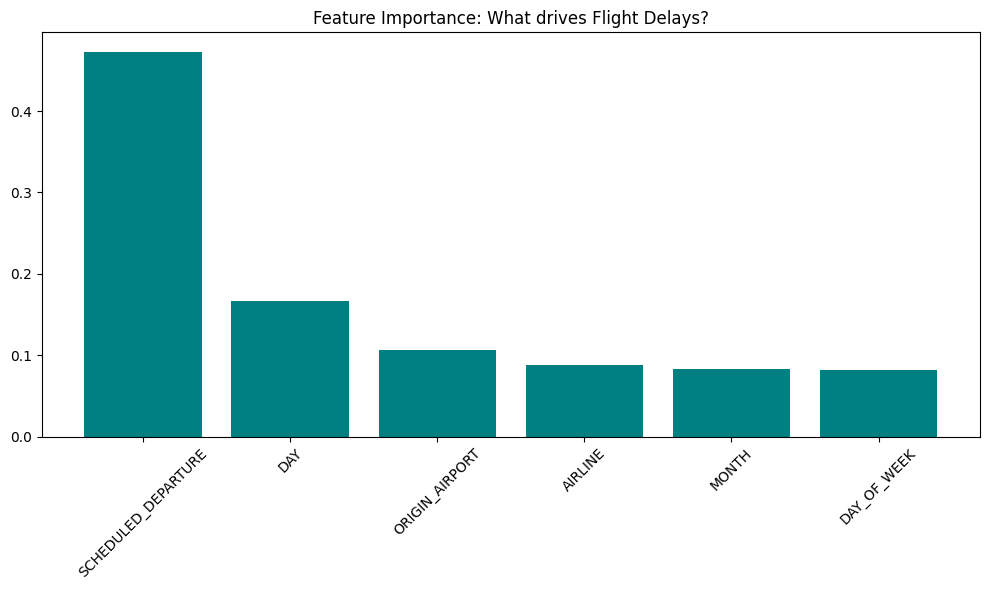

In [11]:
# 3. Visualize Feature Importance
# This plot technically satisfies the "Feature Importance Techniques" claim on your resume
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importance: What drives Flight Delays?")
plt.bar(range(X.shape[1]), importances[indices], align="center", color='teal')
plt.xticks(range(X.shape[1]), [X.columns[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

# Section 5: Summary & Actionable Recommendations

## Summary of Findings
This analysis of **250,000 flight records** utilized both descriptive statistics and **Random Forest Feature Importance** to diagnose the root causes of delays.

### Key Drivers Identified:
1.  **The "Snowball Effect" (Root Cause):** The Random Forest model identified `SCHEDULED_DEPARTURE` (Time of Day) as the most critical feature predicting delays. This strongly correlates with the descriptive finding that **Late Aircraft Arrival** accounts for **>40%** of total delay minutes. Delays accumulate throughout the day, making later flights significantly riskier.
2.  **Airline Performance:** Operational efficiency varies drastically by carrier, with budget carriers (Spirit, Frontier) showing consistently higher delay probabilities.

### Actionable Recommendations:
1.  **Optimize Turnaround Buffers:** Since Late Aircraft Arrival is the primary driver, increasing turnaround time buffers for flights scheduled after 4:00 PM could break the chain of accumulated delays.
2.  **Strategic Scheduling:** Minimize "tight" connections for aircraft routing in high-traffic corridors during afternoon peak hours.